# A Natively Fixed-Point Runtime Reconfigurable FIR Filter Design Method for FPGA Hardware

This notebook demonstrates the operation of the FPGA-based Filter Designer described in [this work](https://github.com/jogomojo/fpga_filter_design).

The hardware design used in this demonstration consists of an FIR Compiler v7 IP, the Filter Designer itself, and a few other IPs to bring it all together. The FIR filter is set up to be reconfigurable at runtime where the Filter Designer generates filter coefficients and programs the filter on-the-fly.

In this notebook we take you through the steps to create a signal to pass through the FIR filter, then use the Filter Designer to create new filters and program the FIR with the new coefficients. The Filter Designer computes the coefficients and programs the FIR filter automatically, requiring only to be given a cutoff frequency, which is performed by writing to a shared memory address.

To work through the notebook, run each cell in order by pressing the ```►``` symbol on the toolbar above, or by selecting the cell and pressing ```CTRL+ENTER```.

## Creating a Signal

To start off we need to import a couple of standard Python libraries to create a signal and plot the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this demo the FIR filter is optimised for a 48 KHz sample rate and 16-bit input, so we use this information to create a 3 second random signal and plot the time-domain representation.

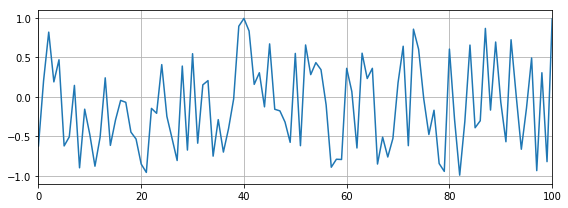

In [2]:
fs = 48000
t = 3 # time in seconds

data = np.random.uniform(-1,1,fs*t) # t-seconds random samples between -1 and 1

# scale to 16 bit for data transfer
data_scaled = np.int16(data/np.max(np.abs(data)) * (2**15)-1)

# plot data
plt.figure(figsize=(8,3))
plt.plot(data)
plt.xlim(0,100)
plt.grid(True)
plt.tight_layout()
plt.show()

## Communicating With The FPGA

Now we have our signal we can set up the hardware on the FPGA. We need to first import the ```Overlay``` and ```allocate``` modules from the PYNQ library.

The ```Overlay``` module allows us to download the bitstream to the FPGA and communicate with the IPs on the design. The ```allocate``` module allows us to create contiguous memory buffers to store the data in.

The final line in the next cell creates an object which points to the DMA on the FPGA.

In [3]:
from pynq import Overlay
from pynq import allocate

ol = Overlay('filter_designer.bit')

dma_data = ol.fir_dma

To make things easier, we create a function ```xfir``` that performs the DMA transfer for us. First it creates the memory buffers, copies the input data to the input buffer, initiates the DMA transfer, then returns the received data stored in the output buffer. 

Note that the FIR filter is set up with a 32-bit output wordlength to allow for bit growth.

In [4]:
def xfir(data):
    # Create buffers
    in_buffer = allocate(shape=(len(data),),dtype=np.int16)
    out_buffer = allocate(shape=(len(data),),dtype=np.int32)

    # Copy data to input buffer
    for i in range(len(data)):
        in_buffer[i] = data[i]

    # Transfer
    dma_data.sendchannel.transfer(in_buffer)
    dma_data.recvchannel.transfer(out_buffer)
    dma_data.sendchannel.wait()
    dma_data.recvchannel.wait()
    
    return out_buffer

Next we create a function that writes a cutoff frequency to the Filter Designer. This is done by writing a value to an AXI-Lite register which we can access through PYNQ's MMIO ```write``` function.

As the Filter Designer takes in a 10-bit fixed-point (all bits fractional) representation of the cutoff frequency, we need to first convert the input float to an integer. The method used here is very simple and can result in some heavily quantised values. To get a better fixed-point representation, MATLAB's Fixed-Point Designer can be used.

Note that the value of ```fc``` should be normalised to the sample rate. For example, 10% of the sample rate would be 0.1.

In [5]:
def make_filter(fc):
    fc_fp = round(fc*2**10)
    ol.filterdesigner_0.write(12, fc_fp)

## Sending and Receving a Signal

Now we have created our functions, we can generate a new filter, pass the signal we created earlier to the ```xfir``` function, then plot the results against the original signal. 

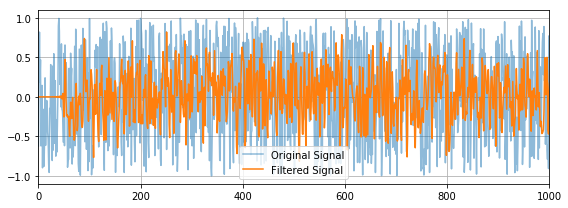

In [6]:
make_filter(0.3) # generate new filter 
data_filt = xfir(data_scaled) # send random signal to FIR and store result
data_filt = data_filt/max(data_filt) # normalise

plt.figure(figsize=(8,3))
plt.plot(data, alpha=0.5, label="Original Signal")
plt.plot(data_filt, label="Filtered Signal")
plt.grid(True)
plt.xlim(0,1000)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

We can now use an FFT to view the original signal and the filtered signal in the frequency domain.

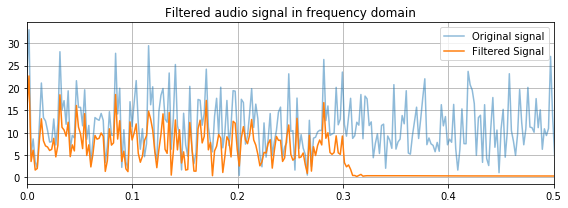

In [7]:
NFFT = 512

data_fft = np.fft.fft(data, NFFT)
data_filt_fft = np.fft.fft(data_filt, NFFT)

plt.figure(figsize=(8,3))
plt.title("Filtered audio signal in frequency domain")
plt.plot(np.linspace(0,1,NFFT),abs(data_fft),alpha=0.5,label="Original signal")
plt.plot(np.linspace(0,1,NFFT),abs(data_filt_fft),label="Filtered Signal")
plt.xlim(0,0.5) # only display up to fs/2
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see from the results, the recieved signal is working as expected.

You can edit the cells above to try out different cutoff frequencies and plot the results.

## Checking The Impulse Response

We can also check the quality of the filter by sending an impulse through the filter.

Note that you may need to run this next cell a couple of times to get the correct results due to a quirk with the DMA.

In [10]:
make_filter(0.1)

impulse = np.append(0xf,np.zeros(1000))
impulse_response = xfir(impulse)
impulse_response = impulse_response/sum(impulse_response)

Finally, we can plot the time and frequency responses of the filter.

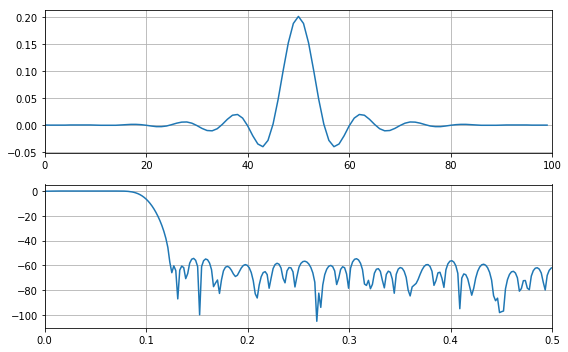

In [11]:
NFFT = 512

ir_fft = np.fft.fft(impulse_response, NFFT)

plt.figure(figsize=(8,5))

plt.subplot(211)
plt.plot(impulse_response[0:100])
plt.xlim(0,100)
plt.grid(True)

plt.subplot(212)
plt.plot(np.linspace(0,1,NFFT),20*np.log10(abs(ir_fft/max(ir_fft))))
plt.xlim(0,0.5)
plt.grid(True)

plt.tight_layout()
plt.show()

Note that, due to the conversion between fixed-point and floating point, the resultant frequency response shown here will not exactly represent the coefficients that have been generated by the Filter Designer.